In [1]:
%pylab inline
import pandas as pd
import seaborn as sns
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

Populating the interactive namespace from numpy and matplotlib


In [2]:
from pyspark import SparkContext

In [3]:
sc = SparkContext()

In [4]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [5]:
sc.parallelize([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]).map(lambda x: x**2).sum()

385

# Create a RDD

In [6]:
wordsList = ['cat', 'elephant', 'rat', 'rat', 'cat']
wordsRDD = sc.parallelize(wordsList, 4)
# Print out the type of wordsRDD
print(type(wordsRDD))

<class 'pyspark.rdd.RDD'>


In [8]:
sc.parallelize(wordsList,4).map(lambda x: len(x)).sum()

20

# Call collect on an RDD: Lazy Spark¶
Spark is lazy. Until you collect, nothing is actually run.

In [9]:
wordsRDD.collect()

['cat', 'elephant', 'rat', 'rat', 'cat']

# Operations on RDDs
From the Spark Programming Guide:

RDDs support two types of operations: transformations, which create a new dataset from an existing one, and actions, which return a value to the driver program after running a computation on the dataset. For example, map is a transformation that passes each dataset element through a function and returns a new RDD representing the results. On the other hand, reduce is an action that aggregates all the elements of the RDD using some function and returns the final result to the driver program (although there is also a parallel reduceByKey that returns a distributed dataset).

In [10]:
def makePlural(word):
    return word + 's'

print (makePlural('cat'))

cats


Transform one RDD into another.

In [13]:
pluralRDD = wordsRDD.map(makePlural)
print (pluralRDD.take(2))
print (pluralRDD.take(3))
#print(pluralRDD.collect())

['cats', 'elephants']
['cats', 'elephants', 'rats']


In [14]:
pluralRDD.take(1)

['cats']

In [15]:
pluralRDD.collect()

['cats', 'elephants', 'rats', 'rats', 'cats']

# WORD COUNT!

**This little exercise shows how to use mapreduce to calculate the counts of individual words in a list.**

In [18]:
wordsList = ['cat', 'elephant', 'rat', 'rat', 'cat']
wordsRDD = sc.parallelize(wordsList, 4)
wordCountsCollected = (wordsRDD
                       .map(lambda w: (w, 1))
                       .reduceByKey(lambda x,y: x+y)
                       .collect())
print (wordCountsCollected)

[('cat', 2), ('elephant', 1), ('rat', 2)]


In [19]:
print ((wordsRDD
    .map(lambda w: (w, 1))
    .reduceByKey(lambda x,y: x+y)).toDebugString())

b'(4) PythonRDD[31] at RDD at PythonRDD.scala:52 []\n |  MapPartitionsRDD[30] at mapPartitions at PythonRDD.scala:132 []\n |  ShuffledRDD[29] at partitionBy at NativeMethodAccessorImpl.java:0 []\n +-(4) PairwiseRDD[28] at reduceByKey at <ipython-input-19-de218d677346>:3 []\n    |  PythonRDD[27] at reduceByKey at <ipython-input-19-de218d677346>:3 []\n    |  ParallelCollectionRDD[21] at parallelize at PythonRDD.scala:194 []'


# Using Cache

In [20]:
wordsList = ['cat', 'elephant', 'rat', 'rat', 'cat']
wordsRDD = sc.parallelize(wordsList, 5)
print (wordsRDD)
wordsRDD.count()

ParallelCollectionRDD[32] at parallelize at PythonRDD.scala:194


5

**Normally, every operation is run from the start. This may be inefficient in many cases. So when appropriate, we may want to cache the result the first time an operation is run on an RDD.**

In [21]:
#this is rerun from the start
wordsRDD.count()

5

In [22]:
#default storage level (MEMORY_ONLY)
wordsRDD.cache()#nothing done this is still lazy

ParallelCollectionRDD[32] at parallelize at PythonRDD.scala:194

In [23]:
#parallelize is rerun and cached because we told it to cache
wordsRDD.count()

5

In [24]:
#this `sc.parallelize` is not rerun in this case
wordsRDD.count()

5

**Where is this useful: it is when you have branching parts or loops, so that you don't do things again and again. Spark, being "lazy" will rerun the chain again. So cache or persist serves as a checkpoint, breaking the RDD chain or the lineage.**

In [25]:
birdsList=['heron','owl']
animList=wordsList+birdsList

animaldict={}
for e in wordsList:
    animaldict[e]='mammal'
for e in birdsList:
    animaldict[e]='bird'
animaldict

{'cat': 'mammal',
 'elephant': 'mammal',
 'heron': 'bird',
 'owl': 'bird',
 'rat': 'mammal'}

In [26]:
animsrdd = sc.parallelize(animList, 4)
animsrdd.cache()
#below runs the whole chain but causes cache to be populated
mammalcount=animsrdd.filter(lambda w: animaldict[w]=='mammal').count()
#now only the filter is carried out
birdcount=animsrdd.filter(lambda w: animaldict[w]=='bird').count()
print (mammalcount, birdcount)

5 2


In [27]:
animsrdd.filter(lambda w: len(w) == 3).count()

5

Exercises: Fun with MapReduce
Read http://spark.apache.org/docs/latest/programming-guide.html for some useful background and then try out the following exercises

The file ./sparklect/english.stop.txt contains a list of English stopwords, while the file ./sparklect/shakes/juliuscaesar.txt contains the entire text of Shakespeare's 'Julius Caesar'.

Load all of the stopwords into a Python list
Load the text of Julius Caesar into an RDD using the sparkcontext.textfile() method. Call it juliusrdd.

In [35]:
# your turn
# Load English stopwords and the text of Julius Caesar
stopwords = open ('english.stop.txt', 'r').read().split('\n')
juliusrdd = sc.textFile('juliuscaesar.txt')

In [36]:
juliusrdd.collect()

['1599',
 'THE TRAGEDY OF JULIUS CAESAR',
 '',
 'by William Shakespeare',
 '',
 '',
 '',
 'Dramatis Personae',
 '',
 '  JULIUS CAESAR, Roman statesman and general',
 "  OCTAVIUS, Triumvir after Caesar's death, later Augustus Caesar,",
 '    first emperor of Rome',
 '  MARK ANTONY, general and friend of Caesar, a Triumvir after his',
 'death',
 '  LEPIDUS, third member of the Triumvirate',
 '  MARCUS BRUTUS, leader of the conspiracy against Caesar',
 '  CASSIUS, instigator of the conspiracy',
 '  CASCA,          conspirator against Caesar',
 '  TREBONIUS,           "          "     "',
 '  CAIUS LIGARIUS,      "          "     "',
 '  DECIUS BRUTUS,       "          "     "',
 '  METELLUS CIMBER,     "          "     "',
 '  CINNA,               "          "     "',
 '  CALPURNIA, wife of Caesar',
 '  PORTIA, wife of Brutus',
 '  CICERO,     senator',
 '  POPILIUS,      "',
 '  POPILIUS LENA, "',
 '  FLAVIUS, tribune ',
 '  MARULLUS, tribune',
 '  CATO,     supportor of Brutus',
 '  LUC

### How many words does Julius Caesar have? Hint: use flatMap().

In [37]:
# your turn
# Remove all punctuations and turn all words into lowercase
import string

table = str.maketrans({key: None for key in string.punctuation})
juliusrdd = juliusrdd.map(lambda x: x.lower().translate(table).split())

### Now print the first 20 words of Julius Caesar as a Python list.

In [38]:
# your turn
from itertools import chain
wordsrdd = juliusrdd.flatMap(chain)
wordsrdd.count()

21201

In [39]:
juliusrdd.collect()

[['1599'],
 ['the', 'tragedy', 'of', 'julius', 'caesar'],
 [],
 ['by', 'william', 'shakespeare'],
 [],
 [],
 [],
 ['dramatis', 'personae'],
 [],
 ['julius', 'caesar', 'roman', 'statesman', 'and', 'general'],
 ['octavius',
  'triumvir',
  'after',
  'caesars',
  'death',
  'later',
  'augustus',
  'caesar'],
 ['first', 'emperor', 'of', 'rome'],
 ['mark',
  'antony',
  'general',
  'and',
  'friend',
  'of',
  'caesar',
  'a',
  'triumvir',
  'after',
  'his'],
 ['death'],
 ['lepidus', 'third', 'member', 'of', 'the', 'triumvirate'],
 ['marcus',
  'brutus',
  'leader',
  'of',
  'the',
  'conspiracy',
  'against',
  'caesar'],
 ['cassius', 'instigator', 'of', 'the', 'conspiracy'],
 ['casca', 'conspirator', 'against', 'caesar'],
 ['trebonius'],
 ['caius', 'ligarius'],
 ['decius', 'brutus'],
 ['metellus', 'cimber'],
 ['cinna'],
 ['calpurnia', 'wife', 'of', 'caesar'],
 ['portia', 'wife', 'of', 'brutus'],
 ['cicero', 'senator'],
 ['popilius'],
 ['popilius', 'lena'],
 ['flavius', 'tribune'],
 

### Now print the first 20 words of Julius Caesar, after removing all the stopwords. Hint: use filter().

In [41]:
wordsrdd = wordsrdd.filter(lambda w: w not in stopwords) 
print (wordsrdd.count())
wordsrdd.take(20)

9118


['1599',
 'tragedy',
 'julius',
 'caesar',
 'william',
 'shakespeare',
 'dramatis',
 'personae',
 'julius',
 'caesar',
 'roman',
 'statesman',
 'general',
 'octavius',
 'triumvir',
 'caesars',
 'death',
 'augustus',
 'caesar',
 'emperor']

### Now, use the word counting MapReduce code you've seen before. Count the number of times each word occurs and print the top 20 results as a list of tuples of the form (word, count). Hint: use takeOrdered() instead of take()

In [46]:
wordCountsCollected = (wordsrdd
                       .map(lambda w: (w, 1))
                       .reduceByKey(lambda x,y: x+y)
                       .takeOrdered(20, key=lambda x: -x[1]))
print (wordCountsCollected)

[('brutus', 366), ('caesar', 237), ('cassius', 227), ('antony', 128), ('thou', 116), ('casca', 72), ('good', 71), ('citizen', 69), ('men', 64), ('lucius', 59), ('man', 56), ('thee', 54), ('thy', 54), ('messala', 47), ('lord', 44), ('rome', 43), ('octavius', 43), ('enter', 43), ('caesars', 42), ('cinna', 40)]


### Plot a bar graph. For each of the top 20 words on the X axis, represent the count on the Y axis.

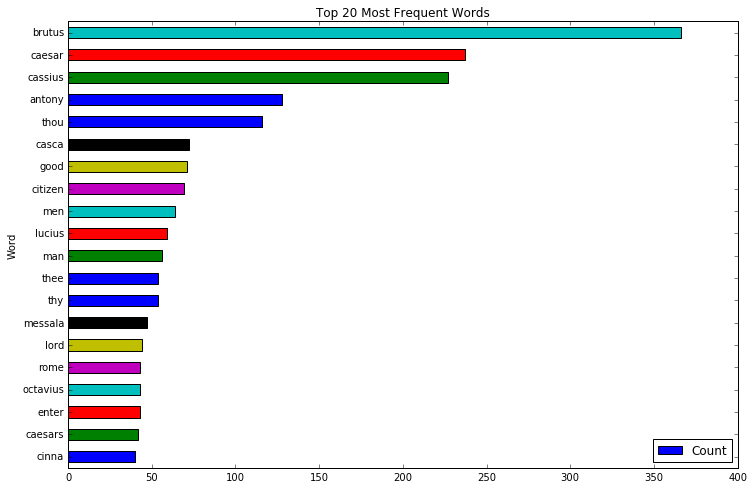

In [47]:
pd.DataFrame(wordCountsCollected, columns=['Word', 'Count']).sort_values('Count').plot(x='Word', 
                                                                              y='Count', 
                                                                              kind='barh', 
                                                                              figsize=(12,8))
plt.title('Top 20 Most Frequent Words')
plt.show()

### Using partitions for parallelization

In order to make your code more efficient, you want to use all of the available processing power, even on a single laptop. If your machine has multiple cores, you can tune the number of partitions to use all of them! From http://www.stat.berkeley.edu/scf/paciorek-spark-2014.html:

You want each partition to be able to fit in the memory availalbe on a node, and if you have multi-core nodes, you want that as many partitions as there are cores be able to fit in memory.

For load-balancing you'll want at least as many partitions as total computational cores in your cluster and probably rather more partitions. The Spark documentation suggests 2-4 partitions (which they also seem to call slices) per CPU. Often there are 100-10,000 partitions. Another rule of thumb is that tasks should take at least 100 ms. If less than that, you may want to repartition to have fewer partitions.

In [48]:
shakesrdd=sc.textFile("shakes/*.txt", minPartitions=4)

In [49]:
shakesrdd.take(10)

['1594',
 'THE TAMING OF THE SHREW',
 '',
 'by William Shakespeare',
 '',
 '',
 '',
 'Dramatis Personae',
 '',
 '    Persons in the Induction']

### Now calculate the top 20 words in all of the files that you just read.

In [50]:
# your turn
# Remove all punctuations and turn all words into lowercase

translator = str.maketrans('', '', string.punctuation)
shakesrdd = shakesrdd.map(lambda x: x.lower().translate(translator).split())

In [51]:
# Count the frequency for each word
word_counts = shakesrdd.flatMap(chain).map(lambda t: (t, 1)).reduceByKey(lambda x,y: x+y)

In [52]:
# Remove stopwords and print 20 most frequent words
word_counts.filter(lambda x: x[0] not in stopwords).takeOrdered(20, key=lambda x: -x[1])

[('thou', 2129),
 ('thy', 1548),
 ('sir', 1320),
 ('thee', 1257),
 ('good', 1200),
 ('lord', 1116),
 ('love', 939),
 ('enter', 892),
 ('hath', 793),
 ('man', 783),
 ('ill', 768),
 ('make', 654),
 ('tis', 613),
 ('king', 596),
 ('give', 574),
 ('duke', 568),
 ('speak', 528),
 ('brutus', 478),
 ('time', 471),
 ('exit', 443)]

### Optional topic 1: DataFrames
Pandas and Spark dataframes can be easily converted to each other, making it easier to work with different data formats. This section shows some examples of each.

Convert Spark DataFrame to Pandas

pandas_df = spark_df.toPandas()

Create a Spark DataFrame from Pandas

spark_df = context.createDataFrame(pandas_df)

In [53]:
df=pd.read_csv("01_heights_weights_genders.csv")
df.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


### Convert this pandas dataframe to a Spark dataframe

In [55]:
from pyspark.sql import SQLContext
sqlsc=SQLContext(sc)
sparkdf = sqlsc.createDataFrame(df)
sparkdf

DataFrame[Gender: string, Height: double, Weight: double]

In [56]:
sparkdf.show(5)

+------+-----------------+----------------+
|Gender|           Height|          Weight|
+------+-----------------+----------------+
|  Male|  73.847017017515|241.893563180437|
|  Male|68.78190404589029|  162.3104725213|
|  Male|74.11010539178491|  212.7408555565|
|  Male| 71.7309784033377|220.042470303077|
|  Male| 69.8817958611153|206.349800623871|
+------+-----------------+----------------+
only showing top 5 rows



In [57]:
type(sparkdf.Gender)

pyspark.sql.column.Column

In [58]:
# You can't call .map() on a DataFrame directly - you first have to convert it into an RDD
temp = sparkdf.rdd.map(lambda r: r.Gender)
print (type(temp))
temp.take(10)

<class 'pyspark.rdd.PipelinedRDD'>


['Male',
 'Male',
 'Male',
 'Male',
 'Male',
 'Male',
 'Male',
 'Male',
 'Male',
 'Male']

# Machine Learning using Spark

In [59]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.regression import LabeledPoint

Now create a data set from the Spark dataframe

In [60]:
data=sparkdf.rdd.map(lambda row: LabeledPoint(row.Gender=='Male',[row.Height, row.Weight]))
data.take(5)

[LabeledPoint(1.0, [73.847017017515,241.893563180437]),
 LabeledPoint(1.0, [68.78190404589029,162.3104725213]),
 LabeledPoint(1.0, [74.11010539178491,212.7408555565]),
 LabeledPoint(1.0, [71.7309784033377,220.042470303077]),
 LabeledPoint(1.0, [69.8817958611153,206.349800623871])]

In [61]:
data2=sparkdf.rdd.map(lambda row: LabeledPoint(row[0]=='Male',row[1:]))
data2.take(1)[0].label, data2.take(1)[0].features

(1.0, DenseVector([73.847, 241.8936]))

In [62]:
train, test = data.randomSplit([0.8,0.2])
train.cache()
test.cache()

PythonRDD[85] at RDD at PythonRDD.scala:52

In [63]:
type(train)

pyspark.rdd.PipelinedRDD

**Train the logistic regression model using MLLIB**

In [64]:
model = LogisticRegressionWithLBFGS.train(train)

In [65]:
model.weights

DenseVector([-0.4808, 0.1978])

In [66]:
results = test.map(lambda lp: (lp.label, float(model.predict(lp.features))))
print (results.take(10))
type(results)

[(1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 0.0), (1.0, 0.0), (1.0, 1.0)]


pyspark.rdd.PipelinedRDD

### Measure accuracy and other metrics

In [67]:
test_accuracy=results.filter(lambda x: x[0]==x[1]).count()/float(results.count())
test_accuracy

0.9178571428571428

In [68]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics
metrics = BinaryClassificationMetrics(results)

In [69]:
print (type(metrics))
metrics.areaUnderROC

<class 'pyspark.mllib.evaluation.BinaryClassificationMetrics'>


0.9178571428571428

In [70]:
type(model)

pyspark.mllib.classification.LogisticRegressionModel

In [71]:
!rm -rf mylogistic.model

In [72]:
model.save(sc, "mylogistic.model")

### The pipeline API automates a lot of this stuff, allowing us to work directly on dataframes.

The pipeline API automates a lot of this stuff, allowing us to work directly on dataframes.

Also see:

http://jordicasanellas.weebly.com/data-science-blog/machine-learning-with-spark

http://spark.apache.org/docs/latest/mllib-guide.html

http://www.techpoweredmath.com/spark-dataframes-mllib-tutorial/

http://spark.apache.org/docs/latest/api/python/

http://spark.apache.org/docs/latest/programming-guide.html

rdd.saveAsTextFile() saves an RDD as a string.

In [73]:
sc.stop()

### Optional Topic 3: Your Turn at Machine Learning! :)
For this exercise, we're going to use one of the datasets we've already worked with: the Boston House Prices dataset. We're going to try a couple of regression algorithms, but from the SparkML library this time.

Before you proceed, make sure to do an overview of the documentation: http://spark.apache.org/docs/latest/api/python/pyspark.ml.html

In [75]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
sc= SparkContext()
sqlContext = SQLContext(sc)

import pandas as pd

**First, we have to load the dataset, which resides as a CSV file in the folder for this exercise.**

In [77]:
# Path: /sparklect/boston.csv
dfBstn = pd.read_csv("BostonHousing.csv")
dfBstn.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [78]:
sparkdfB = sqlContext.createDataFrame(dfBstn)
sparkdfB.take(1)

[Row(crim=0.00632, zn=18.0, indus=2.31, chas=0, nox=0.5379999999999999, rm=6.575, age=65.2, dis=4.09, rad=1, tax=296, ptratio=15.3, b=396.9, lstat=4.98, medv=24.0)]

In [79]:
sparkdfB.cache()
sparkdfB.printSchema()

root
 |-- crim: double (nullable = true)
 |-- zn: double (nullable = true)
 |-- indus: double (nullable = true)
 |-- chas: long (nullable = true)
 |-- nox: double (nullable = true)
 |-- rm: double (nullable = true)
 |-- age: double (nullable = true)
 |-- dis: double (nullable = true)
 |-- rad: long (nullable = true)
 |-- tax: long (nullable = true)
 |-- ptratio: double (nullable = true)
 |-- b: double (nullable = true)
 |-- lstat: double (nullable = true)
 |-- medv: double (nullable = true)



In [80]:
sparkdfB.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
crim,506,3.6135235573122535,8.601545105332491,0.00632,88.9762
zn,506,11.363636363636363,23.32245299451514,0.0,100.0
indus,506,11.136778656126504,6.860352940897589,0.46,27.74
chas,506,0.0691699604743083,0.2539940413404101,0,1
nox,506,0.5546950592885372,0.11587767566755584,0.385,0.871
rm,506,6.284634387351788,0.7026171434153232,3.5610000000000004,8.78
age,506,68.57490118577078,28.148861406903595,2.9,100.0
dis,506,3.795042687747034,2.10571012662761,1.1296,12.1265
rad,506,9.549407114624506,8.707259384239366,1,24


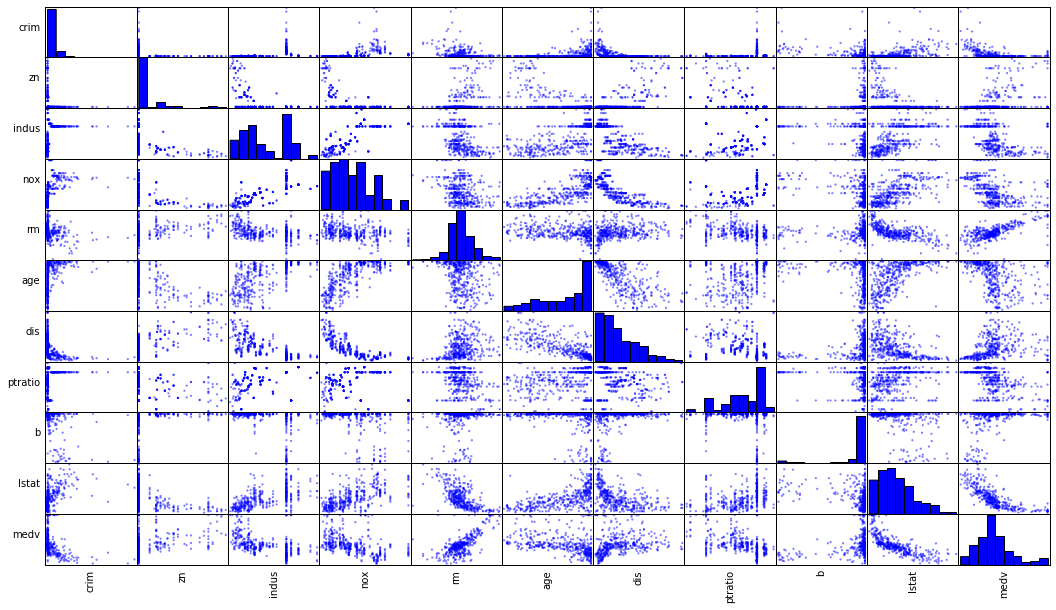

In [81]:
%matplotlib inline
numeric_features = [t[0] for t in sparkdfB.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = sparkdfB.select(numeric_features).sample(False, 0.8).toPandas()
axs = pd.plotting.scatter_matrix(sampled_data, figsize=(18, 10))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [82]:
import six
for i in sparkdfB.columns:
    if not(isinstance(sparkdfB.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to medv for ", i, sparkdfB.stat.corr('medv',i))

Correlation to medv for  crim -0.38830460858681154
Correlation to medv for  zn 0.3604453424505433
Correlation to medv for  indus -0.4837251600283728
Correlation to medv for  chas 0.1752601771902987
Correlation to medv for  nox -0.42732077237328203
Correlation to medv for  rm 0.69535994707154
Correlation to medv for  age -0.3769545650045961
Correlation to medv for  dis 0.249928734085904
Correlation to medv for  rad -0.38162623063977735
Correlation to medv for  tax -0.46853593356776674
Correlation to medv for  ptratio -0.5077866855375622
Correlation to medv for  b 0.3334608196570661
Correlation to medv for  lstat -0.7376627261740145
Correlation to medv for  medv 1.0


In [84]:
# We'll first have to vectorize the features
from pyspark.ml.feature import VectorAssembler

In [86]:
vectorAssembler = VectorAssembler(inputCols = [
    'crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'b', 'lstat'], 
                                  outputCol = 'features')
vhouse_df = vectorAssembler.transform(sparkdfB)
vhouse_df = vhouse_df.select(['features', 'medv'])
vhouse_df.show(3)

+--------------------+----+
|            features|medv|
+--------------------+----+
|[0.00632,18.0,2.3...|24.0|
|[0.02731,0.0,7.07...|21.6|
|[0.02729,0.0,7.07...|34.7|
+--------------------+----+
only showing top 3 rows



In [87]:
splits = vhouse_df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

In [88]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol = 'features', labelCol='medv', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [-0.001967844493793368,0.013789516772925644,0.0,2.5329956066218515,-7.762782529032495,3.7973275784362053,0.0,-0.8175362888568889,0.0,0.0,-0.693811956790728,0.004500911240729886,-0.6422539521307332]
Intercept: 25.0884343097421


In [89]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 5.225769
r2: 0.695147


In [90]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","medv","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="medv",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+------------------+----+--------------------+
|        prediction|medv|            features|
+------------------+----+--------------------+
| 31.37923244112764|32.7|[0.01300999999999...|
| 16.95604576803617|18.9|[0.0136,75.0,4.0,...|
|38.077864777416025|50.0|[0.01381,80.0,0.4...|
|31.108557233240887|31.6|[0.01432,100.0,1....|
| 35.10607447190006|44.0|[0.01538000000000...|
+------------------+----+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.757619


In [91]:
test_result = lr_model.evaluate(test_df)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 4.19548


In [92]:
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()

numIterations: 11
objectiveHistory: [0.5000000000000004, 0.4346112075910953, 0.2537259838431647, 0.22979851494665537, 0.19590365059248216, 0.19127567600033724, 0.18988904043010593, 0.1880502526573648, 0.18776303603857056, 0.18770164632833222, 0.1876755183184255]
+-------------------+
|          residuals|
+-------------------+
| -6.756625631987955|
|  1.914581846770325|
| -5.232812420975431|
|  5.508324560685438|
|-1.7546582586267192|
|-2.8061832045489794|
|  8.660558248686897|
|  1.716131067911789|
|  7.769330045650918|
|0.06472424807443389|
| 10.799012164262507|
|-1.1825670001616224|
|  5.940693074838315|
|-0.1564848660213869|
| -9.446436545814969|
| -3.894264505398283|
| -3.735849160646385|
|  -2.62881991444592|
| 0.8247715902263231|
|-1.3651227833686264|
+-------------------+
only showing top 20 rows



In [93]:
predictions = lr_model.transform(test_df)
predictions.select("prediction","medv","features").show()

+------------------+----+--------------------+
|        prediction|medv|            features|
+------------------+----+--------------------+
| 31.37923244112764|32.7|[0.01300999999999...|
| 16.95604576803617|18.9|[0.0136,75.0,4.0,...|
|38.077864777416025|50.0|[0.01381,80.0,0.4...|
|31.108557233240887|31.6|[0.01432,100.0,1....|
| 35.10607447190006|44.0|[0.01538000000000...|
| 25.82675677841575|30.1|[0.01709,90.0,2.0...|
| 25.95806518269805|23.1|[0.0187,85.0,4.15...|
|31.500606456566814|34.7|[0.02729,0.0,7.07...|
|29.737302535478957|30.8|[0.02763000000000...|
|26.447241465932372|28.7|[0.02985,0.0,2.18...|
|24.520530695985286|19.4|[0.03466,35.0,6.0...|
|31.197916145154757|28.5|[0.03501999999999...|
| 27.24009872061614|22.0|[0.03537,34.0,6.0...|
|24.881489542079187|22.9|[0.03551,25.0,4.8...|
| 32.57770996631895|35.4|[0.03705,20.0,3.3...|
|23.174127534327376|20.7|[0.03738000000000...|
|25.947351212995123|23.2|[0.03871,52.5,5.3...|
|21.748745990000018|21.1|[0.03961,0.0,5.19...|
|25.004196244

### Decision Tree Regression

In [94]:
from pyspark.ml.regression import DecisionTreeRegressor

dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'medv')
dt_model = dt.fit(train_df)
dt_predictions = dt_model.transform(test_df)
dt_evaluator = RegressionEvaluator(
    labelCol="medv", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 3.47582


### Gradient-boosted tree regression

In [95]:
from pyspark.ml.regression import GBTRegressor

gbt = GBTRegressor(featuresCol = 'features', labelCol = 'medv', maxIter=10)
gbt_model = gbt.fit(train_df)
gbt_predictions = gbt_model.transform(test_df)
gbt_predictions.select('prediction', 'medv', 'features').show(5)

+------------------+----+--------------------+
|        prediction|medv|            features|
+------------------+----+--------------------+
|  34.1207672798396|32.7|[0.01300999999999...|
|17.832550308166955|18.9|[0.0136,75.0,4.0,...|
|47.979009558716825|50.0|[0.01381,80.0,0.4...|
|32.897633115459115|31.6|[0.01432,100.0,1....|
|35.071424355229645|44.0|[0.01538000000000...|
+------------------+----+--------------------+
only showing top 5 rows



In [96]:
gbt_evaluator = RegressionEvaluator(
    labelCol="medv", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 3.12835


Let's compare Linear Regression with a more powerful algorithm - the Random Forest. As the Random Forest has several hyperparameters that can be tuned for maximum accuracy, we're going to need to use k-fold Cross Validation.

First, set up a grid for the hyperparameter search.

In [97]:
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit
from pyspark.ml.regression import RandomForestRegressor

#lr = LinearRegression(featuresCol = 'features', labelCol='medv', maxIter=10, regParam=0.3, elasticNetParam=0.8)
Rf = RandomForestRegressor(featuresCol="features", labelCol='medv')

paramGrid = ParamGridBuilder().build()
"""
    .addGrid(lr.regParam, [0.3, 0.01]) \
    .addGrid(lr.fitIntercept, [False, True])\
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()
"""

'\n    .addGrid(lr.regParam, [0.3, 0.01])     .addGrid(lr.fitIntercept, [False, True])    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])    .build()\n'

** Now, with a Random Forest regressor using k-fold Cross Validation, and find the optimal combination of hyperparameters.**

In [98]:
crossval = CrossValidator(estimator=Rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(predictionCol="prediction", \
                 labelCol="medv",metricName="rmse"),
                          numFolds=2)  # use 3+ folds in practice
  
# Run TrainValidationSplit, and choose the best set of parameters.
#model = crossval.fit(train_df)
model = crossval.fit(train_df)

# Make predictions on test data. model is the model with combination of parameters
# that performed best.
prediction = model.transform(test_df)
prediction.select("features", "medv", "prediction")\
    .show(5)

+--------------------+----+------------------+
|            features|medv|        prediction|
+--------------------+----+------------------+
|[0.01300999999999...|32.7| 32.03065761762626|
|[0.0136,75.0,4.0,...|18.9|19.724248152413562|
|[0.01381,80.0,0.4...|50.0| 42.55345590357355|
|[0.01432,100.0,1....|31.6| 33.49278075594347|
|[0.01538000000000...|44.0|39.617845423775584|
+--------------------+----+------------------+
only showing top 5 rows



## Finally, validate the model on the test set and check the Root Mean Squared Error again.

In [99]:
evaluator = RegressionEvaluator(
    labelCol="medv", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(prediction)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 3.30753


In [100]:
# Stop Spark
sc.stop()